## Notebook to fine tune XGB Model  File No:2

**This notebook predicts LOS Range given patient demographics, primay Diagnosis, Diagnosis category and comorbidities**

### Step 1: Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import time

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn import *

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

### Step 2: Load the data file

In [43]:
rawdata = pd.read_csv('data/DiagVsLOSRangev3.csv', index_col=[0])

data = rawdata

### Step 3 Preprocess the data for the model 

In [44]:
#Drop text column DiagDesc 
data.drop(columns='DiagDesc', inplace=True)

#encode categorical columns
CatgCols = ['Gender', 'Ethinicity', 'Religion', 'MaritalStatus',
       'DiagnosisCategory', 'PrimaryDiag', 'DiagGroup']

le = preprocessing.LabelEncoder()
data = rawdata
data[CatgCols].values.flatten()
le.fit(data[CatgCols].values.flatten().astype(str))
data[CatgCols] = le.transform(data[CatgCols].values.flatten().astype(str)).reshape(data[CatgCols].shape)

# encode predictor variable
lep = preprocessing.LabelEncoder()
lep.fit(data.LosRange)
lep_dict = dict(zip(lep.classes_, lep.transform(lep.classes_)))
print(lep_dict)
data.LosRange = lep.transform(data.LosRange)


{'0:<7': 0, '1:8-14': 1, '2:15-30': 2, '3:31-60': 3, '4:61-120': 4, '5:121-180': 5, '6:180+': 6}


**Choose target and unused columns in the dataset**

In [45]:
## Ignore the first three columns (LosRange, EntitySys, TotalLOS and )
target='LosRange'
NonFeatureCols =['LosRange','EntitySys','TotalLos','DiagDesc',
                 'Religion','MaritalStatus','Gender','Ethinicity']   # always include predictor
featureList = [x for x in data.columns if x not in NonFeatureCols]

### Step 4 Split Train and Test Data sets for validating the model

In [46]:
# Create matrices and dataframes for train/test
X = data[featureList]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=42, shuffle=True)

my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)

### Define function to print summary for base model and cv model

In [6]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
def printPredictions(alg, X, y, featureList):
    # get soft probability predictions
    pred_probabilities = alg.predict_proba(X)
    #Choose class with the max probability as the prediction
    y_hat = np.asarray([np.argmax(line) for line in pred_probabilities])

    print("Accuracy: %.2f%%" % (accuracy_score(y, y_hat) * 100.0))
    print('Precision Score: %0.5f' % precision_score(y, y_hat, average='macro'))
    print('Recall: %0.5f'    % recall_score(y, y_hat, average='macro'))
    cfm = metrics.confusion_matrix(y, y_hat)
    print(cfm)
    if (featureList != ''):
        sorted_idx = alg.feature_importances_.argsort()
        plt.barh(np.array(featureList)[sorted_idx][-20:], alg.feature_importances_[sorted_idx][-20:])
        plt.xlabel("Xgboost Feature Importance")

In [7]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
def printResults(alg, X, y, featureList):
    # get soft probability predictions
    pred_probabilities = alg.predict_proba(X)
    #Choose class with the max probability as the prediction
    y_hat = np.asarray([np.argmax(line) for line in pred_probabilities])

    print('Score: %0.5f' % alg.score(y, y_hat))
    print("Accuracy: %.2f%%" % (accuracy_score(y, y_hat) * 100.0))
    print('Precision: %0.5f' % precision_score(y, y_hat, average='macro'))
    print('Recall: %0.5f'    % recall_score(y, y_hat, average='macro'))
    cfm = metrics.confusion_matrix(y, y_hat)
    print(cfm)
    sorted_idx = alg.feature_importances_.argsort()
    plt.barh(np.array(featureList)[sorted_idx][-20:], alg.feature_importances_[sorted_idx][-20:])
    plt.xlabel("Xgboost Feature Importance")

**Use function below for tuning the model**

In [8]:
def modelfit(alg, xtrain, ytrain, target, featureList,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, label=ytrain, feature_names=featureList)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain,eval_metric='merror')
    #Predict training set:
    dtrain_predictions = alg.predict(xtrain)
    dtrain_predprob = alg.predict_proba(xtrain)
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy  : %0.4f" % metrics.accuracy_score(ytrain, dtrain_predictions))
    print("Precision : %0.4f" % metrics.precision_score(ytrain, dtrain_predictions, average='macro'))
    print("Recall    : %0.4f" % metrics.recall_score(ytrain, dtrain_predictions, average='macro'))
    print("Balanced Accuracy  : %0.4f" % metrics.balanced_accuracy_score(ytrain, dtrain_predictions, adjusted=False))
    print("Precision(wtd) : %0.4f" % metrics.precision_score(ytrain, dtrain_predictions, average='weighted'))
    print("Recall(wtd)    : %0.4f" % metrics.recall_score(ytrain, dtrain_predictions, average='weighted'))
    print("Balanced Accuracy(adj)  : %0.4f" % metrics.balanced_accuracy_score(ytrain, dtrain_predictions, adjusted=True))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp[0:20].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

**This function prints the model tree to the file**

In [9]:
def printModelStats(model, dtrain, dtest, featureList, target):
    # Print Training Predictions
    print("Training Predictions")
    printPredictions(model, dtrain[featureList], dtrain[target], featureList)
    # Print Test Predictions
    print("Test Predictions")
    printPredictions(model, dtest[featureList], dtest[target], featureList = '')
    print('Number of Trees %d' % len(model.get_booster().get_dump()))

def save_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    import xgboost as xgb
    import os
    gvz = xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

### Do not edit above code

**Run based on values from previous model**


Model Report
Accuracy  : 0.9966
Precision : 0.9959
Recall    : 0.9961
Balanced Accuracy  : 0.9961
Precision(wtd) : 0.9966
Recall(wtd)    : 0.9966
Balanced Accuracy(adj)  : 0.9954
Model Fit Time 00h:02m:45s
Training Predictions
Accuracy: 99.66%
Precision Score: 0.99589
Recall: 0.99610
[[1139    0    0    1    0    0    1]
 [   1  547    0    1    0    1    1]
 [   2    0  633    1    0    0    0]
 [   0    0    0  638    0    0    0]
 [   0    0    0    1  602    1    0]
 [   0    0    0    0    0  295    2]
 [   0    1    0    0    0    2  845]]
Test Predictions
Accuracy: 23.47%
Precision Score: 0.17970
Recall: 0.18793
[[175  36  54  43  37  14  36]
 [ 67  24  36  23  20   9  35]
 [ 63  34  22  22  33   8  27]
 [ 59  18  26  21  27   9  36]
 [ 56  10  22  25  32   9  46]
 [ 24  13  13  17  14   2  23]
 [ 48   9  11  40  34  17  93]]
Number of Trees 3500


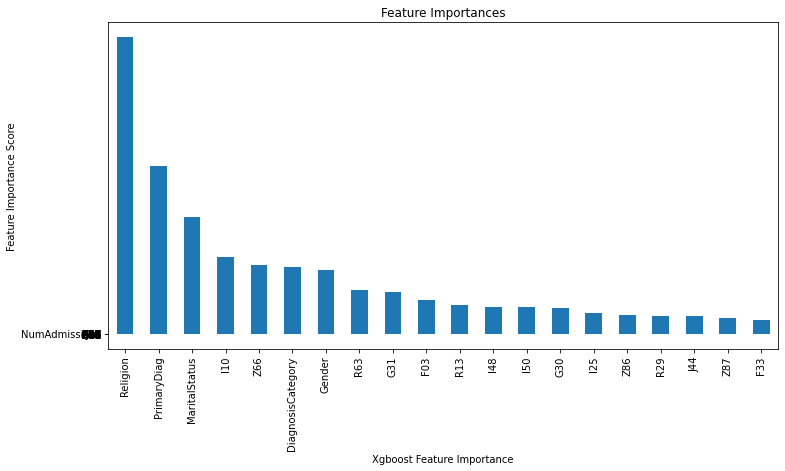

In [23]:
# previous train accuracy was 71%, test accuracy was 29%, max_depth from 5 to 20   **DONE**
# increased base_score from 0.1 to 0.5, increased subsample from 0.6 to 1
# reduced estimators from 1000 to 500, increased learning rate to 0.6 from 0.1
xgb4 = XGBClassifier(
    n_estimators=500,         # num_boosting_rounds passed to fit function
    num_class=7,               # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,   # only for gpu_hist tree methods

    # general parameters
    max_depth= 20,             # default=6 (3-10) lower  underfits
    learning_rate = 0.6,
    verbosity= 0,              # 0:silent 1: Info 2: Warn 3: debug

    booster= 'gbtree',
    #booster parameters
    min_child_weight= 1,       # default=1        higher underfits
    gamma= 0,                  # depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,         # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= 1,            # sample observations for each tree 1 means all
    colsample_bytree= 1,     # cols to sample for each tree
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=1,              # L2 regularization evenly reduce of wts
    reg_alpha=0,               # L1 regularization eliminate weights randomly
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'merror',
    seed= 30,                  # reproducible for parameter tuning. 
    tree_method= 'exact',     # based on column histograms rather than reading observations every time.

    base_score= 0.5,           # initial prediction score for all instances (global bias)
    missing = 0,               # when a value is missing assume 0
    random_state= 35,
    validate_parameters= 1
)
start_time = time.time()
modelfit(xgb4, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, 
         early_stopping_rounds=0)
elapsed = time.time() - start_time
print('Model Fit Time %s' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
printModelStats(xgb4, dtrain, dtest, featureList, target)

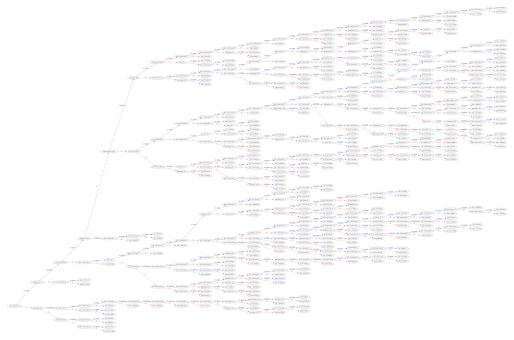

In [27]:
xgb.plot_tree(xgb4, rankdir='LR')
plt.show()

**Training accuracy of xg4 is 99.66. The model has successfuly fit the training data**


Model Report
Accuracy  : 0.9832
Precision : 0.9814
Recall    : 0.9811
Balanced Accuracy  : 0.9811
Precision(wtd) : 0.9833
Recall(wtd)    : 0.9832
Balanced Accuracy(adj)  : 0.9780
Model Fit Time 00h:03m:14s
Training Predictions
Accuracy: 98.32%
Precision Score: 0.98139
Recall: 0.98113
[[1128    2    0    5    3    0    3]
 [   2  542    1    0    0    0    6]
 [   0    3  627    2    2    1    1]
 [   2    5    1  627    0    0    3]
 [   1    1    2    2  593    3    2]
 [   2    1    1    0    2  286    5]
 [   2    2    2    2    2    5  833]]
Test Predictions
Accuracy: 25.57%
Precision Score: 0.20999
Recall: 0.21406
[[167  46  54  45  38  11  34]
 [ 63  29  43  25  25   9  20]
 [ 62  21  35  23  29   8  31]
 [ 51  20  25  30  26  12  32]
 [ 57  16  24  20  37   8  38]
 [ 22  11  13  21  11   4  24]
 [ 34  12  18  41  30  17 100]]
Number of Trees 3500


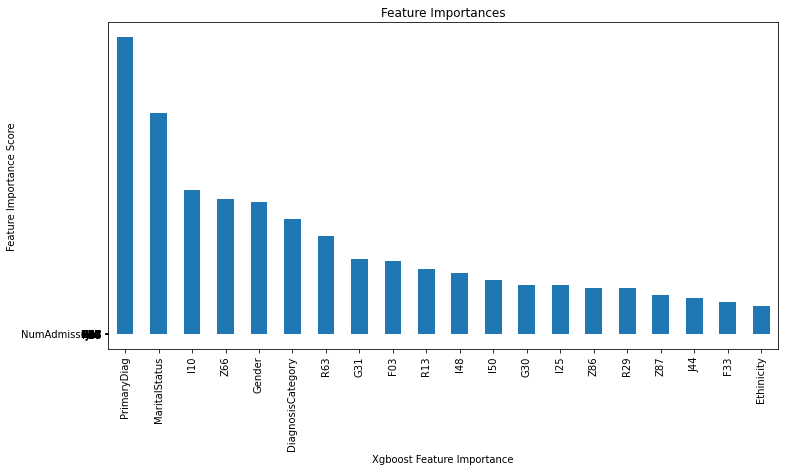

In [28]:
# same as xgb4 but without religion   **DONE**
# Result:
#    Training Accuracy came down to 98.3% from 99.6%
#    Test Accuracty went up from 23.47% to 25.57%
#    Same number of trees 3500.

xgb5 = XGBClassifier(
    n_estimators=500,         # num_boosting_rounds passed to fit function
    num_class=7,               # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,   # only for gpu_hist tree methods

    # general parameters
    max_depth= 20,             # default=6 (3-10) lower  underfits
    learning_rate = 0.6,
    verbosity= 0,              # 0:silent 1: Info 2: Warn 3: debug

    booster= 'gbtree',
    #booster parameters
    min_child_weight= 1,       # default=1        higher underfits
    gamma= 0,                  # depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,         # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= 1,              # sample observations for each tree 1 means all
    colsample_bytree= 1,       # cols to sample for each tree
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=1,              # L2 regularization evenly reduce of wts
    reg_alpha=0,               # L1 regularization eliminate weights randomly
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'merror',
    seed= 30,                  # reproducible for parameter tuning. 
    tree_method= 'exact',     # based on column histograms rather than reading observations every time.

    base_score= 0.5,           # initial prediction score for all instances (global bias)
    missing = 0,               # when a value is missing assume 0
    random_state= 35,
    validate_parameters= 1,
    nthreads=2
)
start_time = time.time()
modelfit(xgb5, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, 
         early_stopping_rounds=0)
elapsed = time.time() - start_time
print('Model Fit Time %s\n\n' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
printModelStats(xgb5, dtrain, dtest, featureList, target)

**Note**   
Feature importance seems reasonable with only 2 demographic features. Primary diagnosis plays a significant role and DiagnosisCategory is also considered important.   
**TODO:** Try what happens if MaritalStatus is ignored. Will it generalize better like religion?

Now that we got an excellent fit, let's try to generalize the model with L1 and L2 regularization.


Model Report
Accuracy  : 0.9665
Precision : 0.9685
Recall    : 0.9621
Balanced Accuracy  : 0.9621
Precision(wtd) : 0.9669
Recall(wtd)    : 0.9665
Balanced Accuracy(adj)  : 0.9558
Model Fit Time 00h:04m:07s


Training Predictions
Accuracy: 96.65%
Precision Score: 0.96854
Recall: 0.96212
[[1114    5    3    8    2    1    8]
 [   5  532    4    1    2    0    7]
 [   8    1  614    2    1    2    8]
 [   6    3    3  613    0    0   13]
 [   4    1    4    3  577    3   12]
 [   4    1    4    1    1  277    9]
 [   6    2    4    2    2    2  830]]
Test Predictions
Accuracy: 27.80%
Precision Score: 0.22531
Recall: 0.23073
[[186  41  48  35  35  10  40]
 [ 74  35  32  20  20   6  27]
 [ 66  24  39  19  27   8  26]
 [ 56  19  15  27  25  10  44]
 [ 43  13  25  26  38  12  43]
 [ 26  11  13  11  14   4  27]
 [ 36  10  25  32  27  14 108]]
Number of Trees 3500


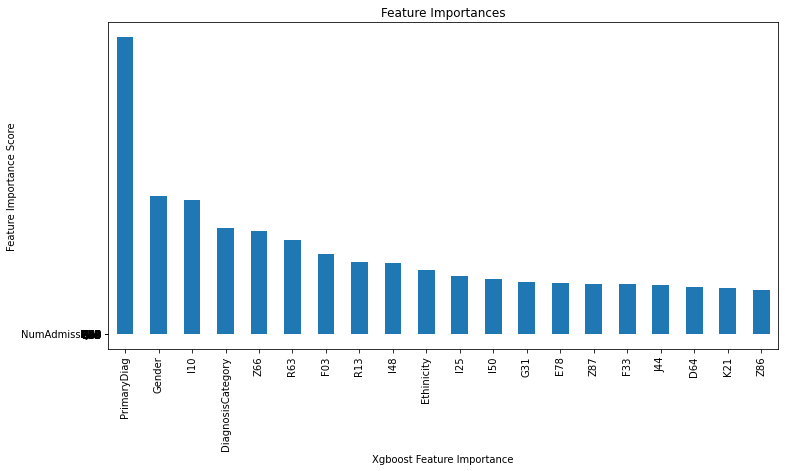

In [41]:
# same as xgb5 with L2 regularization and no MaritalStatus   ***DONE**
# Result:
# Training Accuracy from 98.32% to 96.65%
# Test Accuracty from 25.57% to 27.80%
# Number of trees same 3500 to 
# Note: Changes L1 regularization did not show any improvement

xgb6 = XGBClassifier(
    n_estimators=500,         # num_boosting_rounds passed to fit function
    num_class=7,               # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,   # only for gpu_hist tree methods

    # general parameters
    max_depth= 20,             # default=6 (3-10) lower  underfits
    learning_rate = 0.6,
    verbosity= 0,              # 0:silent 1: Info 2: Warn 3: debug

    booster= 'gbtree',
    #booster parameters
    min_child_weight= 1,       # default=1        higher underfits
    gamma=0,                  # depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,         # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= 1,              # sample observations for each tree 1 means all
    colsample_bytree= 1,       # cols to sample for each tree
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=100,              # L2 regularization evenly reduce of wts
    reg_alpha=0,               # L1 regularization eliminate weights randomly 
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'merror',
    seed= 30,                  # reproducible for parameter tuning. 
    tree_method= 'exact',     # based on column histograms rather than reading observations every time.

    base_score= 0.5,           # initial prediction score for all instances (global bias)
    missing = 0,               # when a value is missing assume 0
    random_state= 35,
    validate_parameters= 1,
    nthreads=4
)
start_time = time.time()
modelfit(xgb6, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, 
         early_stopping_rounds=0)
elapsed = time.time() - start_time
print('Model Fit Time %s\n\n' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
printModelStats(xgb6, dtrain, dtest, featureList, target)


Model Report
Accuracy  : 0.9531
Precision : 0.9590
Recall    : 0.9469
Balanced Accuracy  : 0.9469
Precision(wtd) : 0.9538
Recall(wtd)    : 0.9531
Balanced Accuracy(adj)  : 0.9381
Model Fit Time 00h:03m:57s


Training Predictions
Accuracy: 95.31%
Precision Score: 0.95896
Recall: 0.94694
[[1110    3    5    7    4    1   11]
 [  11  521    5    3    2    0    9]
 [  15    2  602    5    2    2    8]
 [  14    5    5  599    1    0   14]
 [  10    1    3    4  571    3   12]
 [   6    1    4    1    1  271   13]
 [  15    1    6    2    3    1  820]]
Test Predictions
Accuracy: 27.35%
Precision Score: 0.22608
Recall: 0.22872
[[184  37  46  42  34  11  41]
 [ 65  36  35  19  20   9  30]
 [ 68  23  33  19  32   4  30]
 [ 55  22  13  27  28   9  42]
 [ 47  17  24  31  42  10  29]
 [ 24   8  17  14  12   6  25]
 [ 40  13  23  31  31  12 102]]
Number of Trees 3500


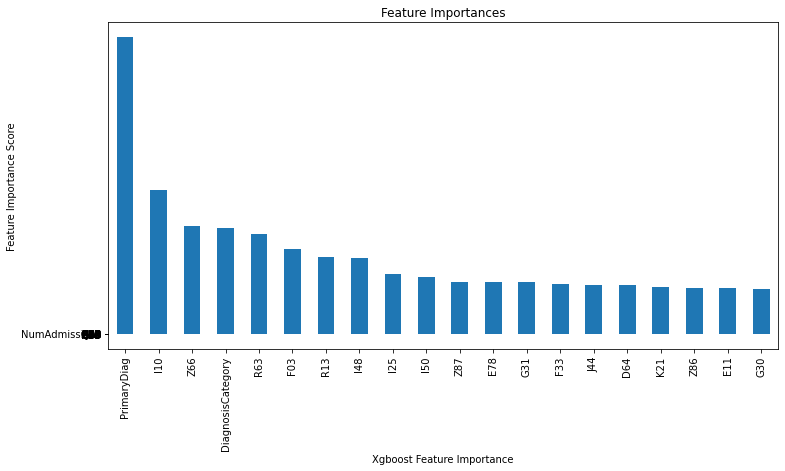

In [50]:
# same as xgb6 with  no Gender or Ethinicity  **DONE**
# Result:
# Training Accuracy from 96.65% to 95.31%
# Test Accuracty from 27.58% to 27.35%
# Number of trees from 3500 to 
# Note: Changes L1 regularization did not show any improvement

xgb7 = XGBClassifier(
    n_estimators=500,         # num_boosting_rounds passed to fit function
    num_class=7,               # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,   # only for gpu_hist tree methods

    # general parameters
    max_depth= 20,             # default=6 (3-10) lower  underfits
    learning_rate = 0.6,
    verbosity= 0,              # 0:silent 1: Info 2: Warn 3: debug

    booster= 'gbtree',
    #booster parameters
    min_child_weight= 1,       # default=1        higher underfits
    gamma=0,                  # depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,         # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= 1,              # sample observations for each tree 1 means all
    colsample_bytree= 1,       # cols to sample for each tree
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=80,              # L2 regularization evenly reduce of wts
    reg_alpha=0,               # L1 regularization eliminate weights randomly 
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'merror',
    seed= 30,                  # reproducible for parameter tuning. 
    tree_method= 'exact',     # based on column histograms rather than reading observations every time.

    base_score= 0.5,           # initial prediction score for all instances (global bias)
    missing = 0,               # when a value is missing assume 0
    random_state= 35,
    validate_parameters= 1,
    nthreads=4
)
start_time = time.time()
modelfit(xgb7, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, 
         early_stopping_rounds=0)
elapsed = time.time() - start_time
print('Model Fit Time %s\n\n' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
printModelStats(xgb7, dtrain, dtest, featureList, target)


Model Report
Accuracy  : 0.9508
Precision : 0.9577
Recall    : 0.9448
Balanced Accuracy  : 0.9448
Precision(wtd) : 0.9517
Recall(wtd)    : 0.9508
Balanced Accuracy(adj)  : 0.9356
Model Fit Time 00h:04m:31s


Training Predictions
Accuracy: 95.08%
Precision Score: 0.95775
Recall: 0.94476
[[1107    4    6    6    4    1   13]
 [  12  521    4    2    2    0   10]
 [  17    2  597    6    2    2   10]
 [  16    5    4  597    1    0   15]
 [  10    1    2    5  570    3   13]
 [   7    1    3    0    1  271   14]
 [  16    1    6    2    2    1  820]]
Test Predictions
Accuracy: 27.04%
Precision Score: 0.22361
Recall: 0.22694
[[178  37  50  42  34  14  40]
 [ 70  37  34  18  18   6  31]
 [ 63  30  34  19  31   3  29]
 [ 54  26  12  30  23  10  41]
 [ 45  21  22  29  36  12  35]
 [ 24   8  17  14  10   6  27]
 [ 41  13  23  31  29  11 104]]
Number of Trees 3500


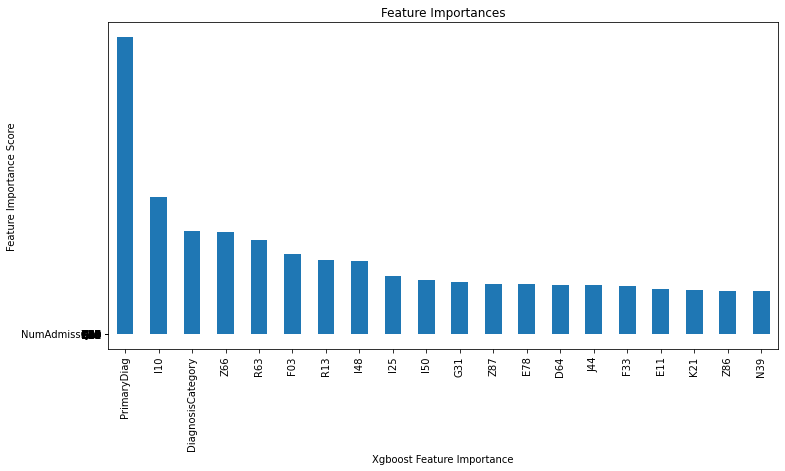

In [51]:
# same as xgb7 with default path for missing values  ** DONE **
# Result:
# Training Accuracy from 95.31% to 95.08%
# Test Accuracty from 27.35% to 27.04%
# Number of trees same 3500 to 
# Default path for missing values did not make difference. go back to xgb7

xgb8 = XGBClassifier(
    n_estimators=500,         # num_boosting_rounds passed to fit function
    num_class=7,               # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,   # only for gpu_hist tree methods

    # general parameters
    max_depth= 20,             # default=6 (3-10) lower  underfits
    learning_rate = 0.6,
    verbosity= 0,              # 0:silent 1: Info 2: Warn 3: debug

    booster= 'gbtree',
    #booster parameters
    min_child_weight= 1,       # default=1        higher underfits
    gamma=0,                  # depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,         # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= 1,              # sample observations for each tree 1 means all
    colsample_bytree= 1,       # cols to sample for each tree
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=100,              # L2 regularization evenly reduce of wts
    reg_alpha=0,               # L1 regularization eliminate weights randomly 
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'merror',
    seed= 30,                  # reproducible for parameter tuning. 
    tree_method= 'exact',     # based on column histograms rather than reading observations every time.

    base_score= 0.5,           # initial prediction score for all instances (global bias)
    #missing = 0,               # when a value is missing assume 0
    random_state= 35,
    validate_parameters= 1,
    nthreads=4
)
start_time = time.time()
modelfit(xgb8, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, 
         early_stopping_rounds=0)
elapsed = time.time() - start_time
print('Model Fit Time %s\n\n' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
printModelStats(xgb8, dtrain, dtest, featureList, target)

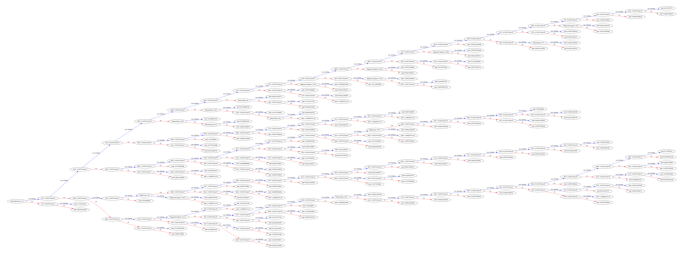

In [52]:
xgb.plot_tree(xgb7, rankdir='LR')
plt.show()

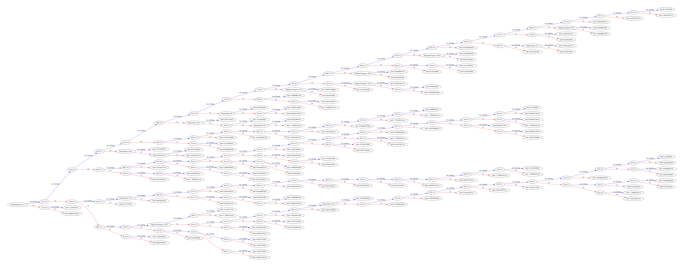

In [53]:
xgb.plot_tree(xgb8, rankdir='LR')
plt.show()